<a href="https://colab.research.google.com/github/danangcrysnanto/bovine-graphs-mapping/blob/master/part2_breedgraphs/analysis/part2_breedgraphs_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Analysis of mapping to the graphs filtered based on breeds

### Description of the data 

Mapped the BSW simulated reads to various scenario of genome graphs. Since we selected a constant number of variants, we repeated graph mapping ten times to account for the effect of the downsampling. 

In [0]:
library(tidyverse)
library(magrittr)

In [0]:
## We download data from github with this base url 
basepath <- "https://raw.githubusercontent.com/danangcrysnanto/bovine-graphs-mapping/master/part2_breedgraphs/result/"

File `all_rep_stat.tsv` contained the statistics from all graph mapping scenarios, where:
The description for each columns is as follow:    
- bin : bin data according to mq that increasing by 10
- FP : number of reads that incorrectly mapped
- total: number of reads mapped
- TP: number of reads incorrectly mapped
- FP_sum: Cumulative sum of incorrectly mapped reads that has minimum mapping quality of that bin
- TP_sum: Cumulative sum of correctly mapped reads that has minimum mapping quality of that bin
- total_sum: Total of mapped reads at that given bin
- FPR: FP_sum/(FP_sum+TP_sum)
- TPR: TP_sum/(TP_sum+FP_sum)
- mode: Mapping mode (single end, se) or (paired end, pe)
- breeds : Reference graphs used (BSW, OBV, HOL, FV, pangenome, random, vgref or bwa)
- prog: Aligner to use (vg/bwa)
- replication: No of replicates

In [6]:
datstat <- read.table(url(file.path(basepath,"all_rep_stat.tsv")),header=TRUE)
str(datstat)
head(datstat)

'data.frame':	960 obs. of  14 variables:
 $ bin        : Factor w/ 6 levels "(10,20]","(20,30]",..: 5 4 3 2 1 6 5 4 3 2 ...
 $ mq         : num  60 46.2 35.8 24.9 16.4 ...
 $ FP         : int  32 14 16 36 30 7187 45 30 40 98 ...
 $ total      : int  9936870 10962 12206 10078 8768 21116 9719635 40386 48345 50933 ...
 $ TP         : int  9936838 10948 12190 10042 8738 13929 9719590 40356 48305 50835 ...
 $ TP_sum     : int  9936838 9947786 9959976 9970018 9978756 9992685 9719590 9759946 9808251 9859086 ...
 $ FP_sum     : int  32 46 62 98 128 7315 45 75 115 213 ...
 $ total_sum  : int  9936870 9947832 9960038 9970116 9978884 10000000 9719635 9760021 9808366 9859299 ...
 $ FPR        : num  0.00032 0.00046 0.00062 0.00098 0.00128 ...
 $ TPR        : num  99.4 99.5 99.6 99.7 99.8 ...
 $ mode       : Factor w/ 2 levels "pe","se": 1 1 1 1 1 1 2 2 2 2 ...
 $ breeds     : Factor w/ 8 levels "BSW","bwa","FV",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ prog       : Factor w/ 3 levels "bwa","vg","vgref": 2 2 

,bin,mq,FP,total,TP,TP_sum,FP_sum,total_sum,FPR,TPR,mode,breeds,prog,replication
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<int>
1,"(50,60]",59.994113,32,9936870,9936838,9936838,32,9936870,0.00032,99.36838,pe,BSW,vg,10
2,"(40,50]",46.166940,14,10962,10948,9947786,46,9947832,0.00046,99.47786,pe,BSW,vg,10
3,"(30,40]",35.758807,16,12206,12190,9959976,62,9960038,0.00062,99.59976,pe,BSW,vg,10
4,"(20,30]",24.921215,36,10078,10042,9970018,98,9970116,0.00098,99.70018,pe,BSW,vg,10
5,"(10,20]",16.388914,30,8768,8738,9978756,128,9978884,0.00128,99.78756,pe,BSW,vg,10
6,"[0,10]",2.122088,7187,21116,13929,9992685,7315,10000000,0.07315,99.92685,pe,BSW,vg,10


### Data Wrangling

We report the statistics based on the mean across 10 replications.

In [7]:
datstat_av <- datstat %>% group_by(mode,breeds,bin) %>% 
              summarise(FP=mean(FP),
                                  total=mean(total),
                                  FP=mean(FP),
                                  TPR=mean(TPR),
                                  FPR=mean(FPR),
                                  mq=mean(mq))
head(datstat_av)

#Since BWA report might be more than 10 million, due to supplementary alignments. 
#We need to account this in denominator when calculating the ratio of incorrect mapping.

sumtot <- datstat_av %>% group_by(breeds,mode) %>% summarise(tot=sum(total))
datmap2 <- datstat_av %>% left_join(sumtot)
datmap2$FP_prop <- datmap2$FP*100/datmap2$tot

#We will compare the difference of mapping error using barplot. 
#I will divide the height in the bar according to the MQ > 10 or MQ < 10. 
#This threshold is used by GATK to filter reads for variant calling.
datmap2$mqcol <- factor(ifelse(datmap2$mq>=10,"MQ >= 10","MQ < 10"),levels=c("MQ >= 10","MQ < 10"))

mode,breeds,bin,FP,total,TPR,FPR,mq
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pe,BSW,"(10,20]",30.0,8771.2,99.78754,0.001285,16.384281
pe,BSW,"(20,30]",36.0,10063.2,99.70013,0.000985,24.910010
pe,BSW,"(30,40]",16.0,12176.2,99.59986,0.000625,35.758300
pe,BSW,"(40,50]",14.6,10945.2,99.47826,0.000465,46.165647
pe,BSW,"(50,60]",31.9,9936926.8,99.36895,0.000319,59.994113
pe,BSW,"[0,10]",7184.4,21117.4,99.92687,0.073129,2.122174


Joining, by = c("mode", "breeds")


### Plotting the mapping error split by MQ
Divide the height in the bar according to the MQ > 10 or MQ < 10. 
This threshold is used by GATK to filter reads for variant calling.

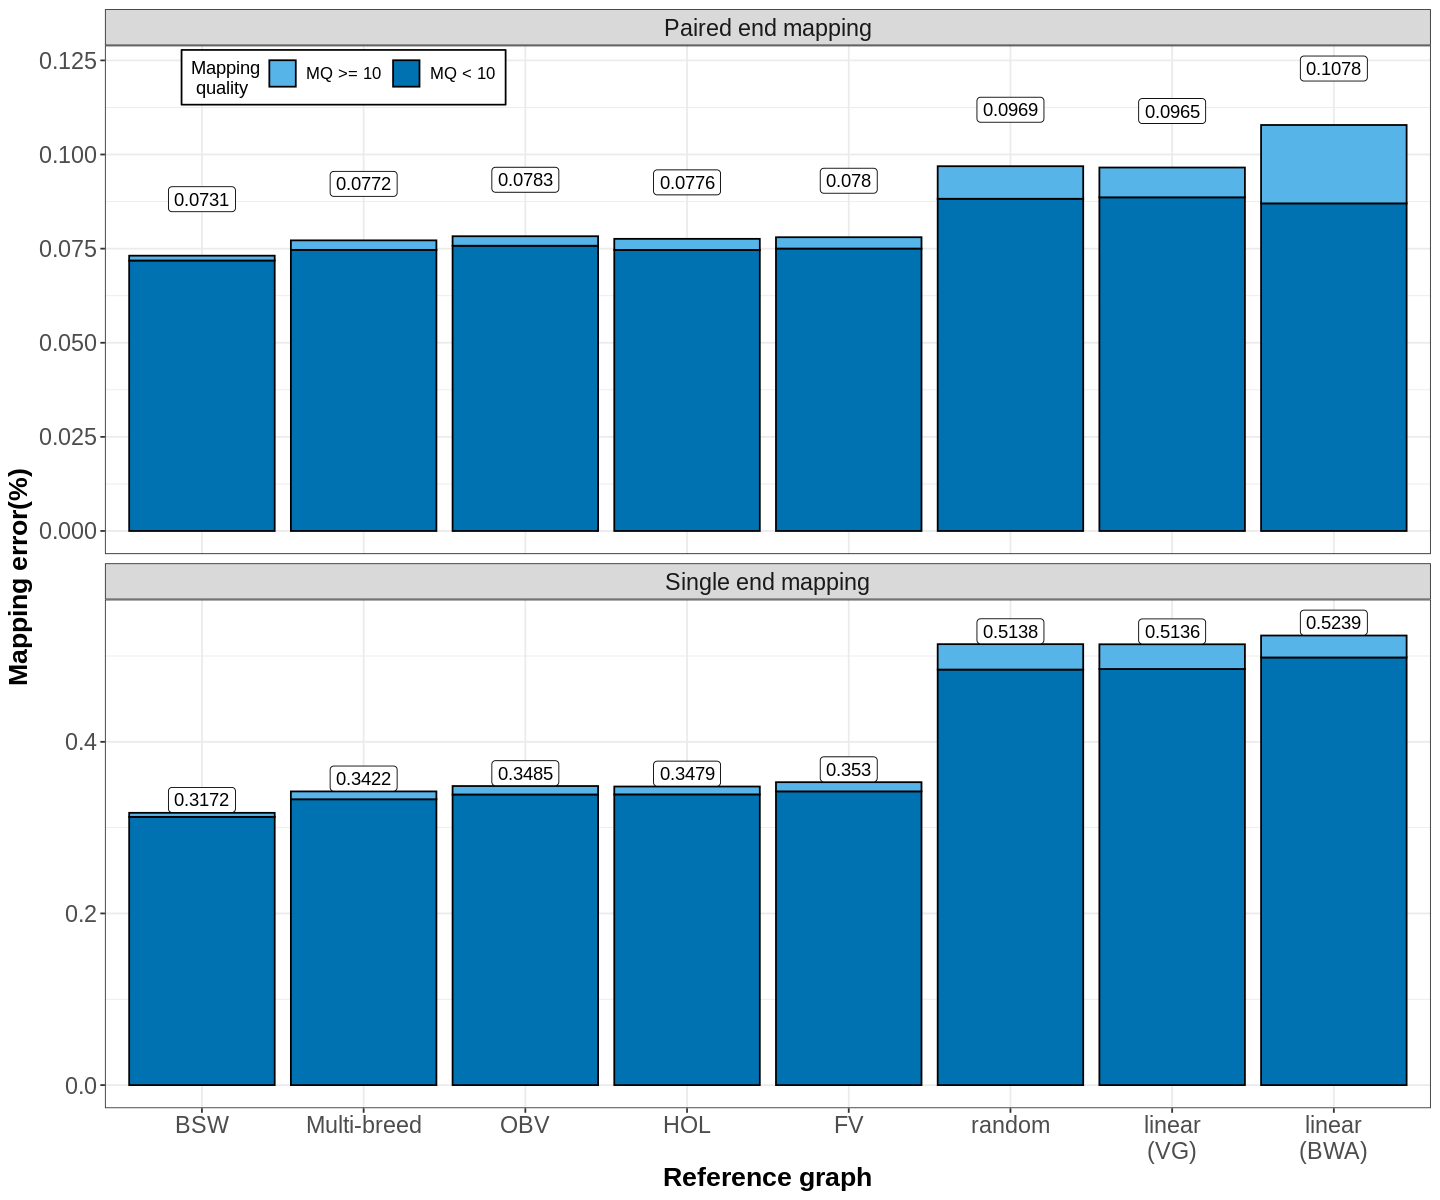

In [8]:
options(repr.plot.width=12, repr.plot.height=10)
facet_label <- c(
  se="Single end mapping",
  pe="Paired end mapping"
)


#first plot---

datmap3 <- datmap2 %>% group_by(mode,breeds,mqcol) %>%  summarise(FP_prop=sum(FP_prop))
datbar <- datmap3 %>% group_by(breeds,mode) %>% summarise(totprop=sum(FP_prop))

datbar$breeds <- factor(datbar$breeds,levels=c("BSW","pangenome","OBV","HOL","FV","random","vgref","bwa"))
datmap3$breeds <- factor(datmap3$breeds,levels=c("BSW","pangenome","OBV","HOL","FV","random","vgref","bwa"))
label_x <- c("BSW","Multi-breed","OBV","HOL","FV","random","linear\n(VG)","linear\n(BWA)")
pl1 <- ggplot(datmap3,aes(x=breeds,
                          y=FP_prop))+
  geom_col(aes(fill=mqcol),size=0.5,col="black")+
  facet_wrap(~mode,nrow=2,scales = "free_y",labeller = labeller(mode=facet_label))+
  geom_label(data=datbar,aes(x=breeds,y=totprop+0.015,label=round(totprop,4)),inherit.aes = FALSE)+
  theme_bw()+
  scale_fill_manual(values=c("#56B4E9","#0072B2"))+
  theme(legend.position = c(0.18,0.97),
        legend.direction = "horizontal",
        legend.background = element_rect(colour = "black"),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16,face="bold"),
        legend.text = element_text(size=10),
        strip.text = element_text(size=14))+
  labs(x="Reference graph",y="Mapping error(%)",fill="Mapping\n quality")+
  scale_x_discrete(label=label_x)

pl1

### Calculate mapping improvement

In [9]:
### coverage 10 million reads of bta25

len_chr  <- 42350435
len_read  <- 150
no_read  <- 10^7

coverage_sim  <- (len_read * no_read)/len_chr
cat("coverage of 10 million reads for bta25")
coverage_sim

coverage of 10 million reads for bta25

[1] 35.41876

In [10]:
### Mapping improvement
genome_length  <- 2715853792
coverage  <- 35
read_length  <- 150
no_sim_read  <- 10^8
sim_pe  <- (0.5239-0.3172)/100
sim_se  <- (0.1078-0.0731)/100

### improvement read count pe
cat("Improvement for pe")
(genome_length * coverage * sim_pe) / read_length

### improvement read count se
cat("Improvement for se")
(genome_length * coverage * sim_se) / read_length

Improvement for pe

[1] 1309856

Improvement for se

[1] 219893.6

### Plotting the relation false positive and true positive rate as pseudo-ROC

Plotting the second plot. The pseudo-ROC, x indicates True Positive Rate and y indicates False Positive Rate.

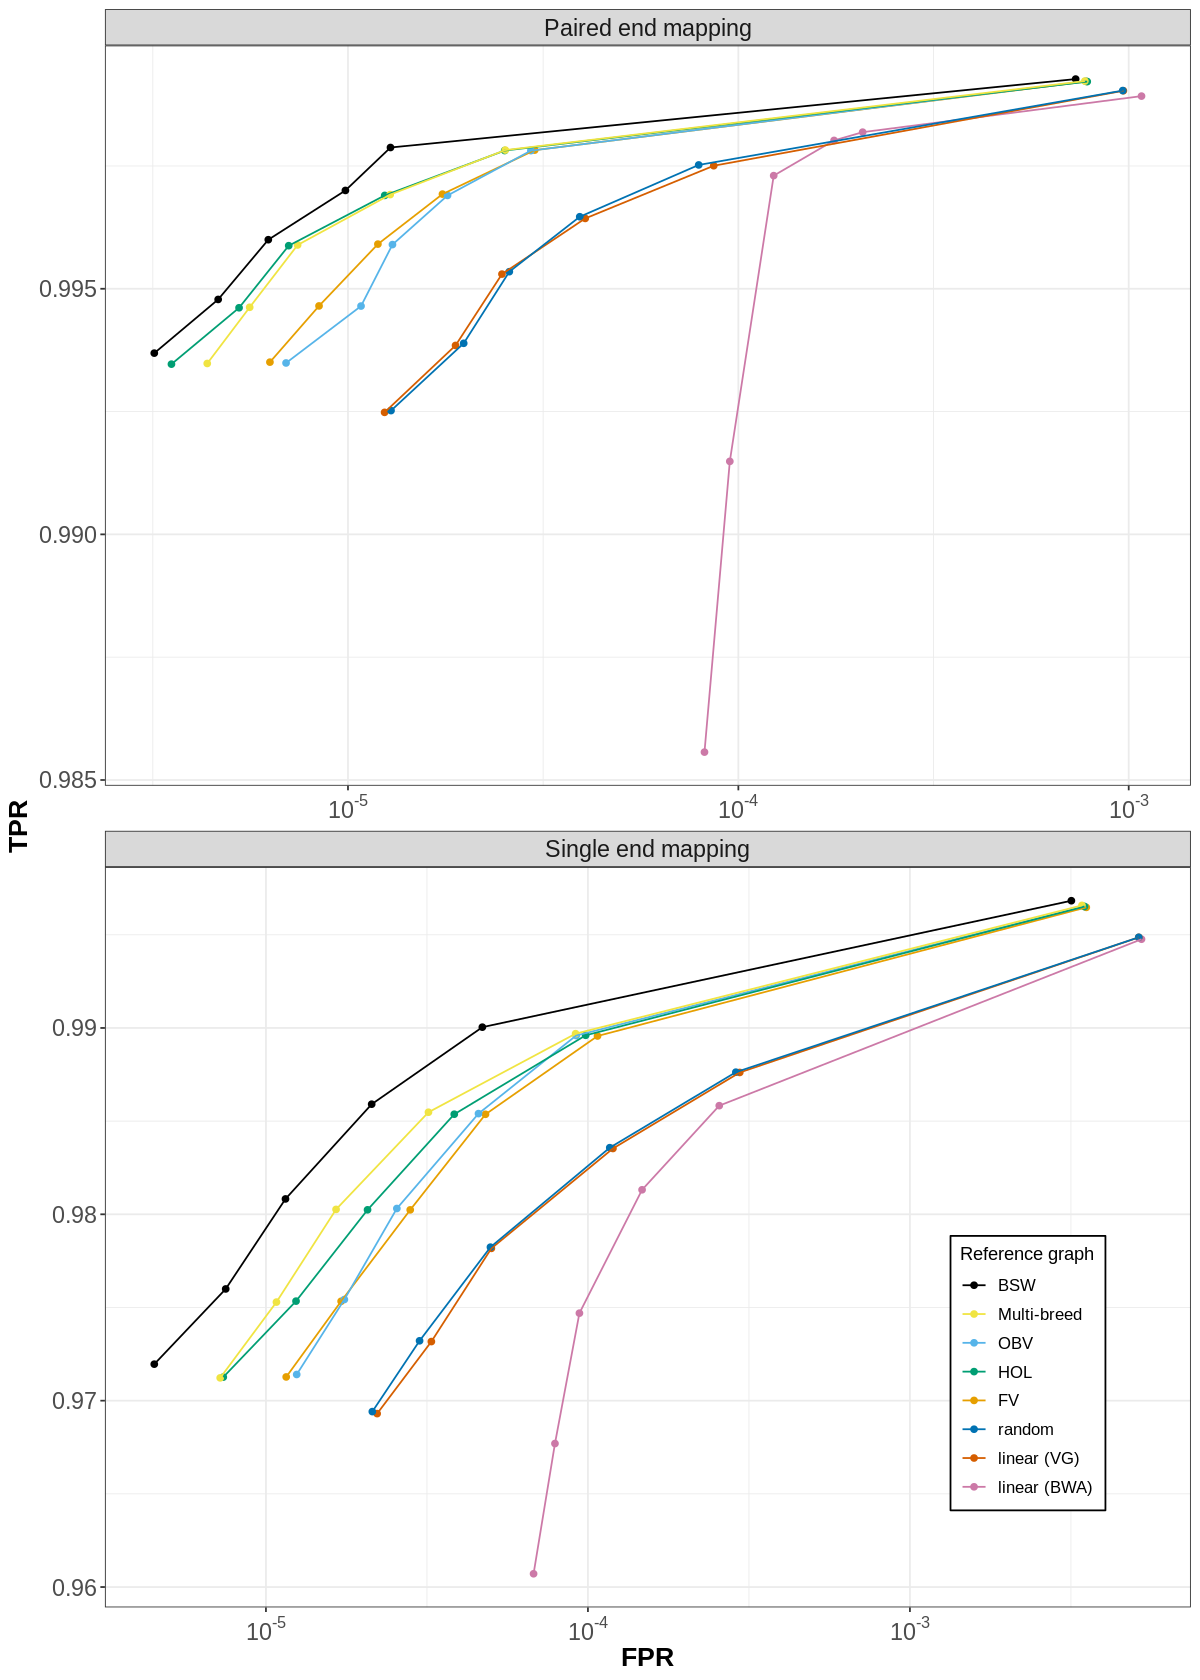

In [11]:
options(repr.plot.width=10, repr.plot.height=14)
label_x <- c("BSW","Multi-breed","OBV","HOL","FV","random","linear (VG)","linear (BWA)")
pl2 <- ggplot(datstat_av,aes(x=FPR/100,y=TPR/100,col=fct_reorder2(breeds,FPR,TPR),group=breeds)) +
  geom_point()+
  geom_line()+
  facet_wrap(~mode,nrow = 2,scales = "free",labeller = labeller(mode=facet_label))+
  scale_x_log10(breaks=c(10^-5,10^-4,10^-3,10^-2,10^-1,0),
                labels=scales::trans_format("log10",scales::math_format(10^.x)))+
  theme_bw()+
  theme(legend.position = c(0.85,0.15),
        legend.background = element_rect(colour = "black"),
        axis.text = element_text(size=14),
        axis.title = element_text(size=16,face = "bold"),
        legend.text = element_text(size=10),
        strip.text = element_text(size=14))+
  scale_color_manual(values=c("#000000", "#F0E442", "#56B4E9", "#009E73",
                              "#E69F00","#0072B2", "#D55E00", "#CC79A7"),
                    label=label_x)+
  labs(x="FPR",y="TPR",col="Reference graph")
pl2

### Statistical test for difference between mapping scenarios

In [12]:
datsum2 <- datstat %>% group_by(breeds,mode,replication) %>% 
  summarise(fp_tot=sum(FP)) %>% 
  left_join(sumtot,by=c("breeds","mode")) %>% 
  mutate(fp_rat=fp_tot*100/tot,
         fp_n=fp_tot+replication) 
datsumse <-  datsum2 %>% filter(mode=="se")
statres <- broom::tidy(pairwise.t.test(x=datsumse$fp_rat,g=datsumse$breeds),p.adjust.methods="bonferonni")
head(statres)

group1,group2,p.value
<chr>,<chr>,<dbl>
bwa,BSW,2.744796e-125
FV,BSW,6.715893e-71
HOL,BSW,2.903336e-66
OBV,BSW,8.909869e-67
pangenome,BSW,5.438229e-60
random,BSW,9.646321e-124


In [0]:
##correcting the axis label

statres  %<>% mutate(group3=case_when(group1=="pangenome"~"Multi-breed",
                                       group1=="bwa"~"Linear (BWA)",
                                       group1=="vgref"~"Linear(VG)",
                                       TRUE~group1
                                      ))

statres  %<>% mutate(group4=case_when(group2=="pangenome"~"Multi-breed",
                                       group2=="bwa"~"Linear (BWA)",
                                       group2=="vgref"~"Linear(VG)",
                                       TRUE~group2
                                      ))


pheat_se  <- ggplot(statres)+
  geom_tile(aes(x=group1,y=group2,fill=p.value),col="black",size=0.75,show.legend = FALSE)+
  geom_text(aes(x=group1,y=group2,label=signif(p.value,2)),size=8,col="white")+
  theme(axis.text=element_text(size=24,face="bold.italic"),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.title = element_blank())+
  scale_fill_gradient(low="skyblue4",high="skyblue3")

Comparison of mapping statistics between mapping scenarios in single-end mode

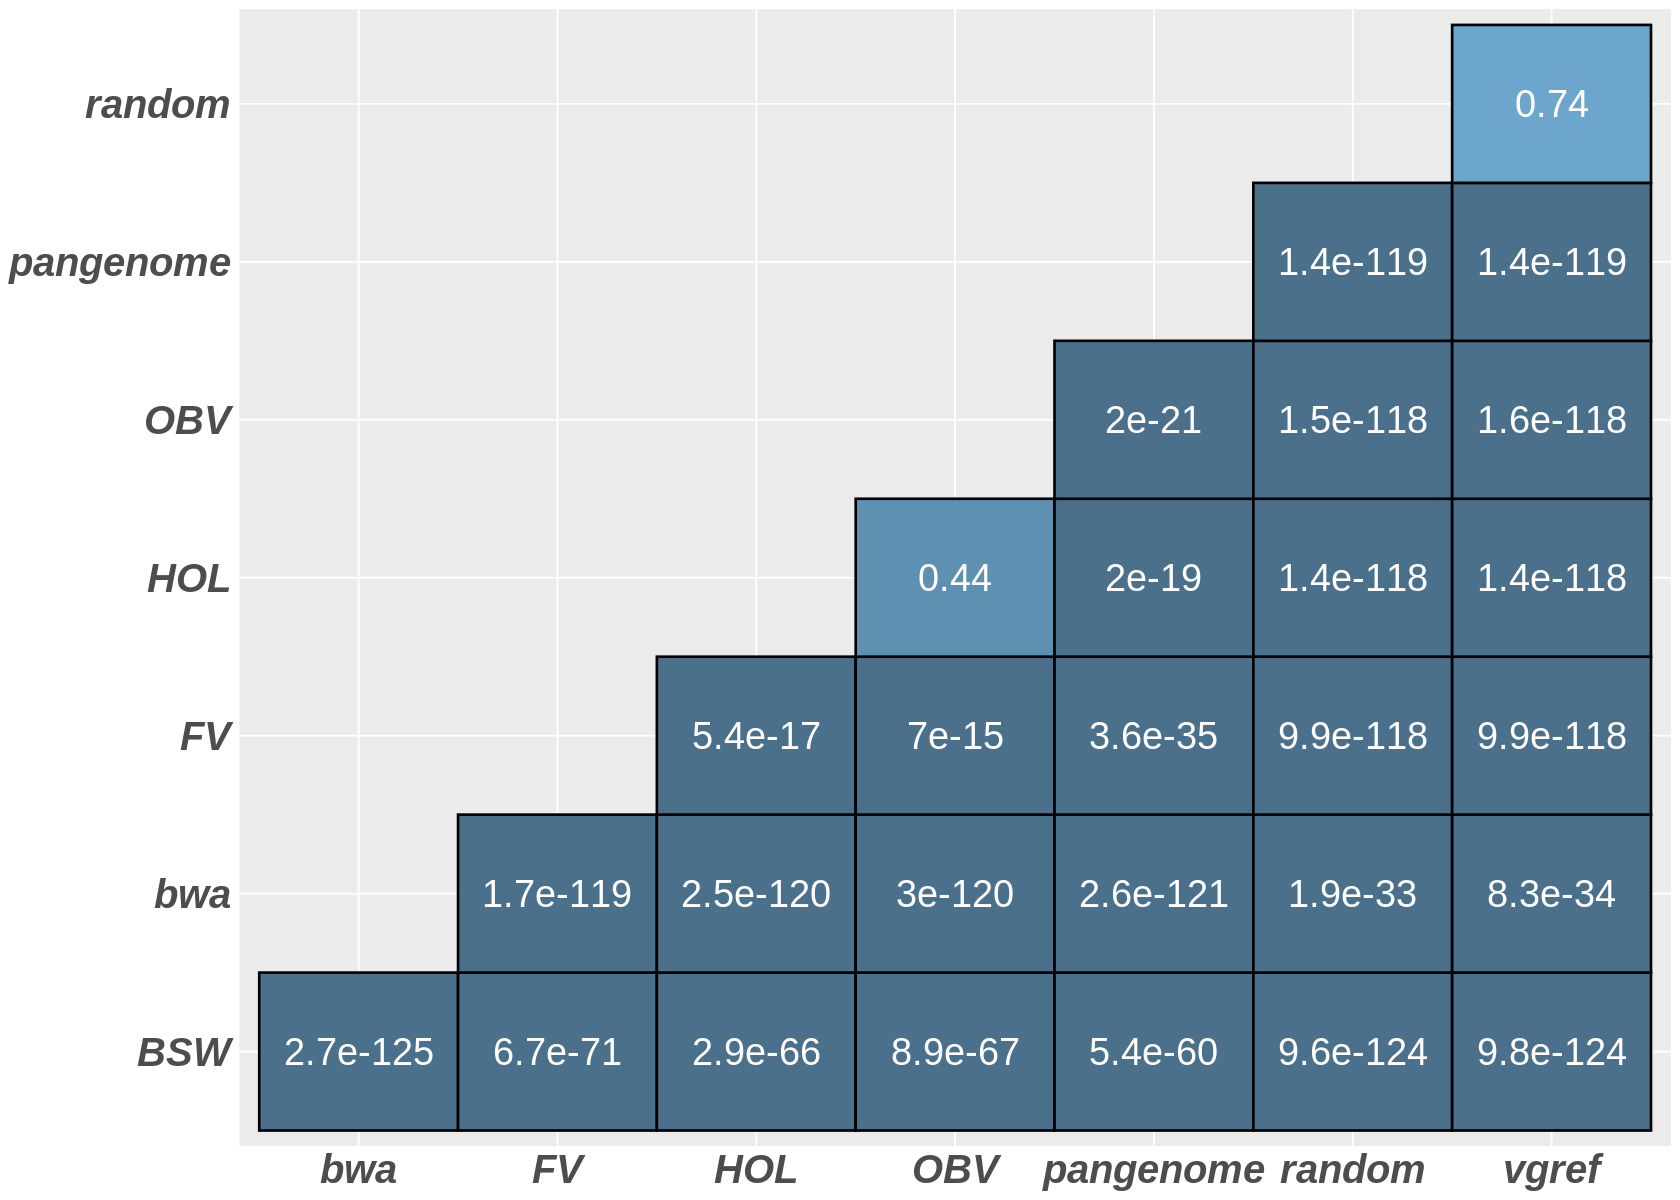

In [22]:
options(repr.plot.width=14, repr.plot.height=10)
cat("Comparison of mapping statistics between mapping scenarios in single-end mode")
pheat_se

Comparison of mapping statistics between mapping scenarios in paired-end mode

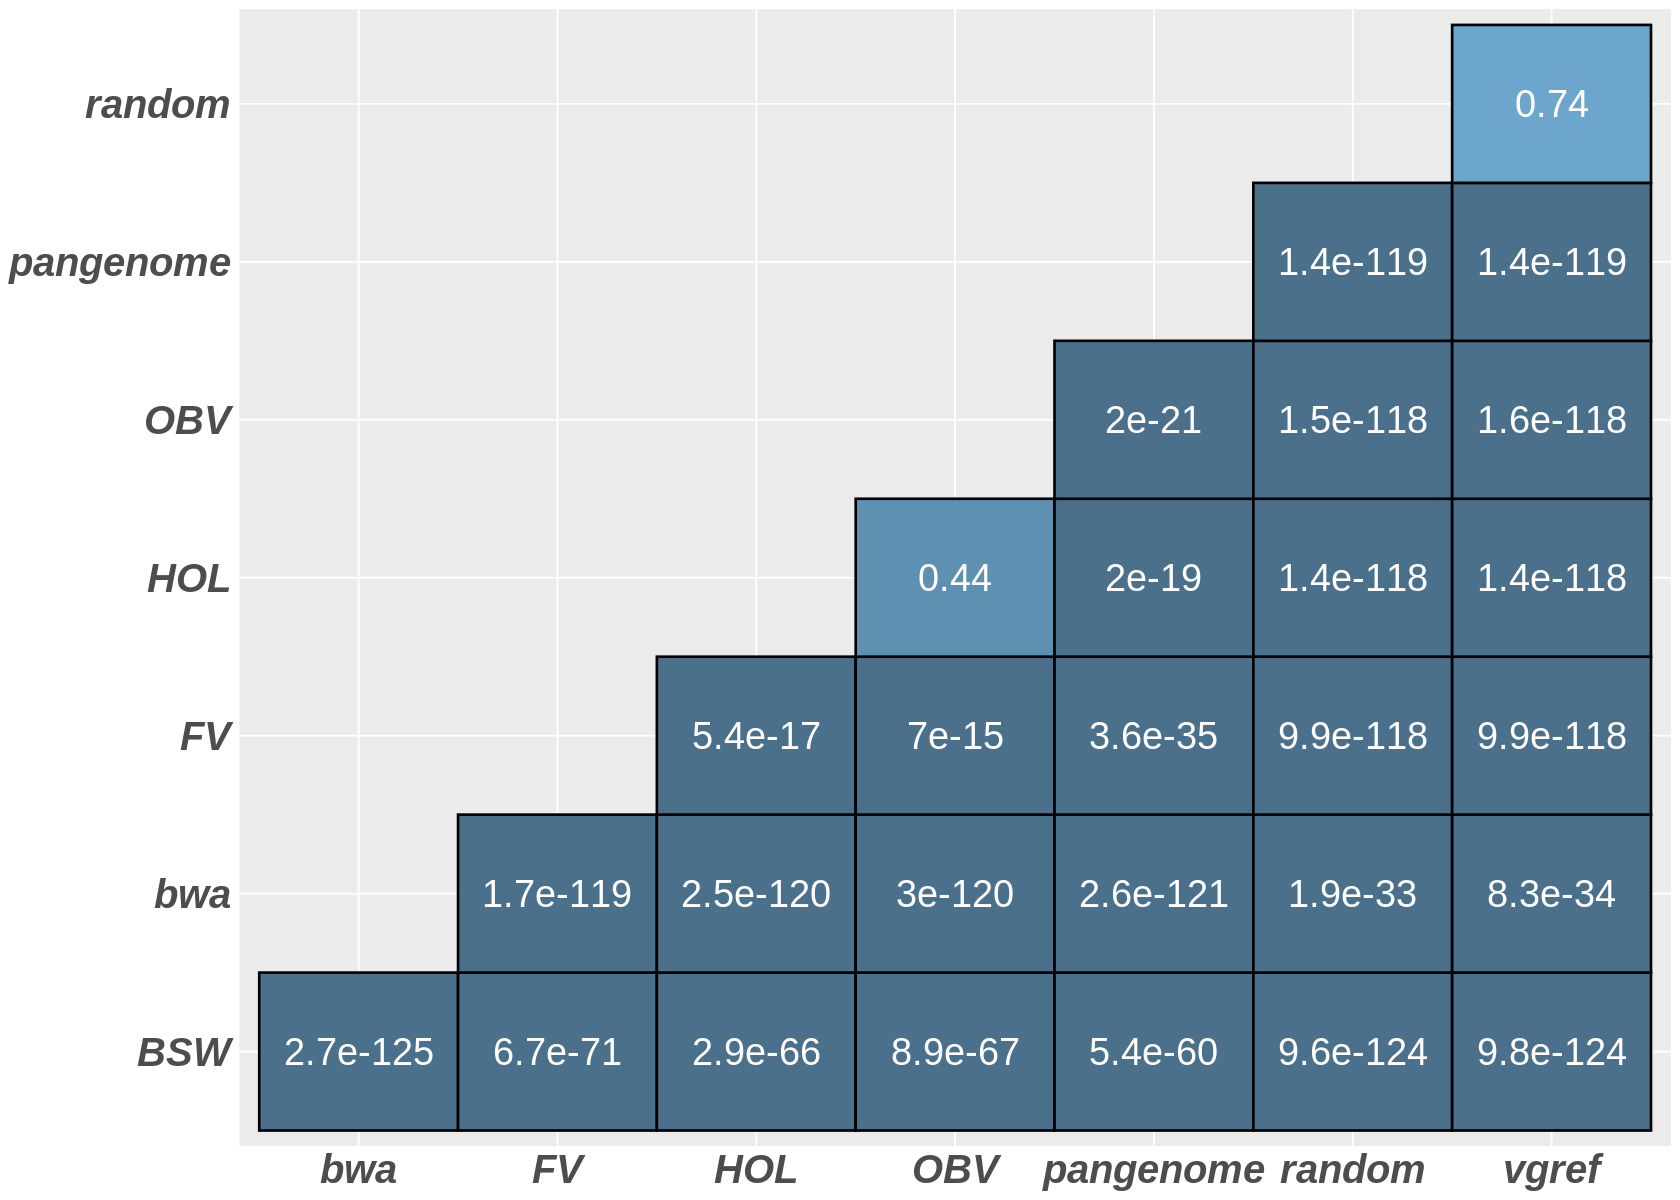

In [21]:
options(repr.plot.width=14, repr.plot.height=10)


pheat_pe  <- ggplot(statres)+
  geom_tile(aes(x=group1,y=group2,fill=p.value),col="black",size=0.75,show.legend = FALSE)+
  geom_text(aes(x=group1,y=group2,label=signif(p.value,2)),size=8,col="white")+
  theme(axis.text=element_text(size=24,face="bold.italic"),
        axis.ticks = element_blank(),
        axis.line = element_blank(),
        axis.title = element_blank())+
  scale_fill_gradient(low="skyblue4",high="skyblue3")

cat("Comparison of mapping statistics between mapping scenarios in paired-end mode")
pheat_pe

### Read mapping analysis based on novelty

Simulated reads annotated whether it contains variations in respect to the reference paths using vg annotate -n (*annotate novelty*). 

In [25]:
datnov <- read.table(url(file.path(basepath,"rep_novelty_all.tsv")),header=TRUE)
head(datnov)

,bin,ident,mq,FP,total,TP,FP_sum,TP_sum,total_sum,PPV,FPR,TPR,mode,breeds,prog,replication
,<fct>,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<int>
1,"(50,60]",novel,59.994660,16,1907158,1907142,16,1907142,1907158,99.99916,0.0008351493,99.54677,pe,BSW,vg,10
2,"(40,50]",novel,46.077159,4,2281,2277,20,1909419,1909439,99.99895,0.0010439367,99.66563,pe,BSW,vg,10
3,"(30,40]",novel,35.511222,1,2005,2004,21,1911423,1911444,99.99890,0.0010961335,99.77023,pe,BSW,vg,10
4,"(20,30]",novel,25.577778,13,1665,1652,34,1913075,1913109,99.99822,0.0017746924,99.85646,pe,BSW,vg,10
5,"(10,20]",novel,15.862021,4,1435,1431,38,1914506,1914544,99.99802,0.0019834797,99.93115,pe,BSW,vg,10
6,"[0,10]",novel,3.900078,187,1281,1094,225,1915600,1915825,99.98826,0.0117442877,99.98826,pe,BSW,vg,10


In [0]:
datnov$breeds <- factor(datnov$breeds,levels=c("BSW","pangenome","OBV","HOL","FV","random","vgref","bwa"))

datstat_nov <- datnov %>% group_by(mode,breeds,bin,ident) %>% 
              summarise(FP=mean(FP),
                                  total=mean(total),
                                  FP=mean(FP),
                                  TPR=mean(TPR),
                                  FPR=mean(FPR),
                                  mq=mean(mq))

In [27]:
### how many reads are novel or not
datnov  %>% filter(breeds=="BSW" & mode=="pe")   %>% group_by(ident)  %>% summarise(count=sum(total)*10^2/10^8)

ident,count
<fct>,<dbl>
novel,19.15825
ref,80.84175


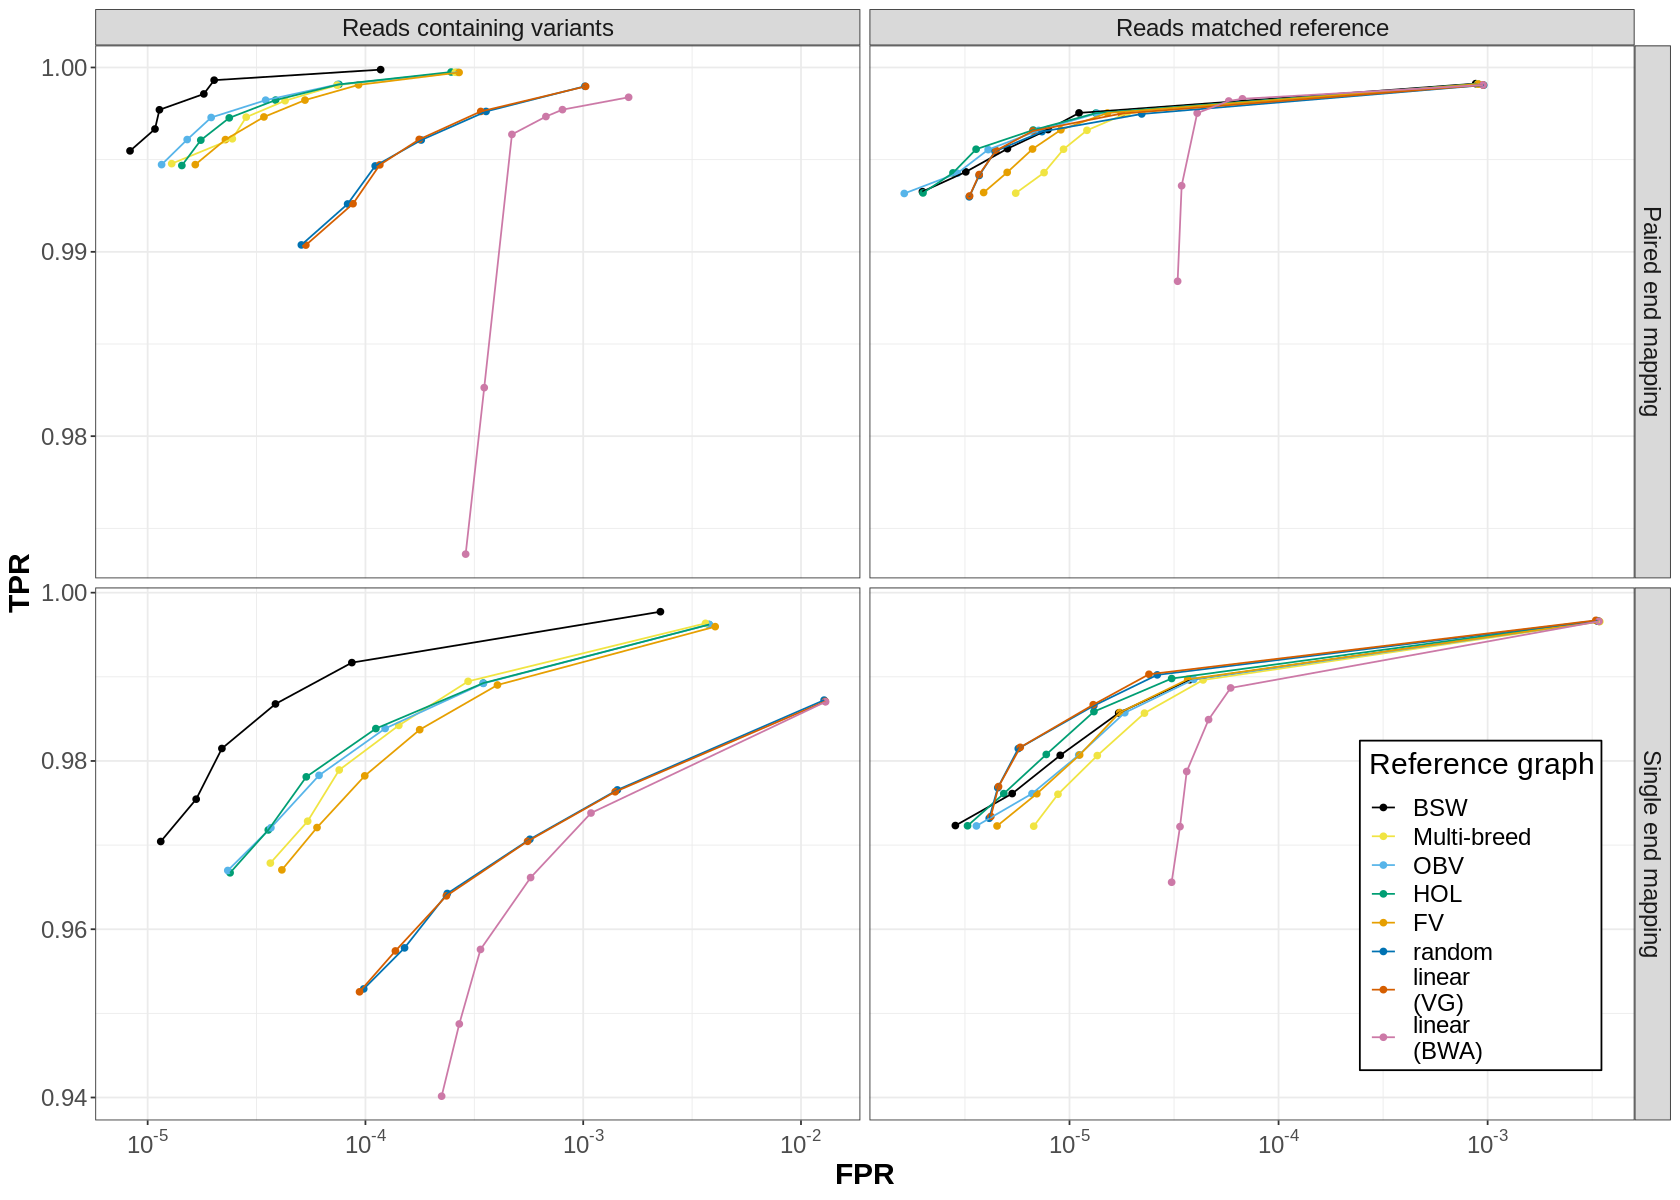

In [28]:
options(repr.plot.width=14, repr.plot.height=10)

label_mode <- c(
  se="Single end mapping",
  pe="Paired end mapping"
)

label_ident <- c(
  novel="Reads containing variants",
  ref="Reads matched reference"
)

datstat_nov$graph <- factor(datstat_nov$breeds,levels=c("BSW","pangenome","OBV","HOL","FV","random","vgref","bwa"))

label_x <- c("BSW","Multi-breed","OBV","HOL","FV","random","linear\n(VG)","linear\n(BWA)")
proc_nov <- ggplot(datstat_nov,aes(x=FPR/100,y=TPR/100,col=fct_reorder2(breeds,FPR,TPR)))+
  geom_point()+
  geom_line()+
  facet_grid(mode~ident,
             scales = "free",
             labeller = labeller(mode=label_mode,
                                   ident=label_ident))+
  theme_bw()+
  scale_color_manual(values=c("#000000", "#F0E442", "#56B4E9", "#009E73",
                              "#E69F00","#0072B2", "#D55E00", "#CC79A7"),
                    label=label_x)+
  scale_x_log10(breaks=c(10^-5,10^-4,10^-3,10^-2,10^-1,0),
               labels=scales::trans_format("log10",scales::math_format(10^.x)))+
  theme(text=element_text(size=18),
        legend.position = c(0.9,0.2),
        legend.background = element_rect(color="black"),
        axis.title = element_text(face = "bold"))+
  labs(col="Reference graph",
       x="FPR",
       y="TPR")
proc_nov

### Plot incorrect mapping by read type 

In [29]:
datstat_nov$breeds <- factor(datstat_nov$breeds,levels=c("BSW","pangenome","OBV","HOL","FV","random","vgref","bwa"))
datv2 <- datstat_nov %>% filter(mode=="pe") %>% group_by(ident,breeds) %>% 
  summarise(FP=sum(FP)*100/10000000,
            total=sum(total))

datv2_sum <- datv2 %>% group_by(breeds) %>% 
  summarise(total_err=sum(FP))
head(datv2_sum)

breeds,total_err
<fct>,<dbl>
BSW,0.073129
pangenome,0.077201
OBV,0.078295
HOL,0.077601
FV,0.078031
random,0.096895


Plot incorrect mapping by read novelty for paired-end mapping

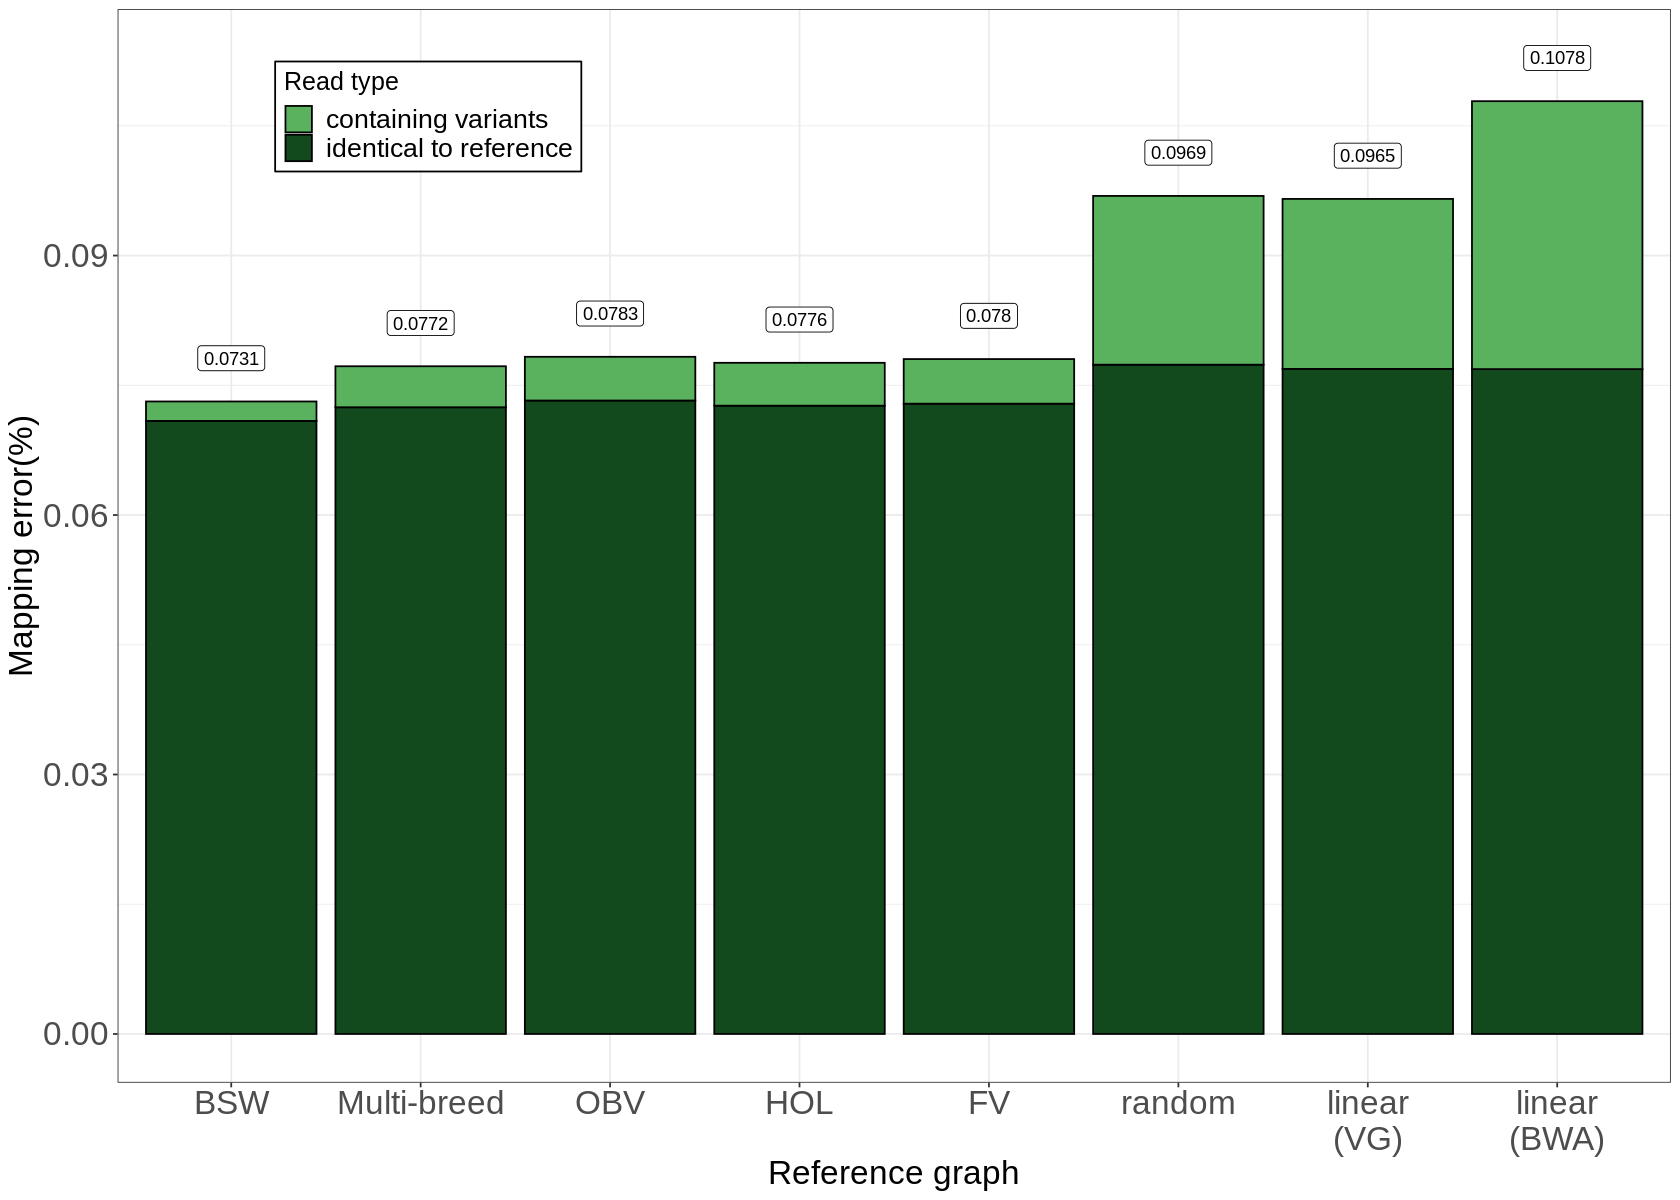

In [30]:
label_x <- c("BSW","Multi-breed","OBV","HOL","FV","random","linear\n(VG)","linear\n(BWA)")
pl1 <- ggplot(datv2,aes(x=breeds,y=FP)) +
  geom_col(aes(fill=ident),col="black") +
  geom_label(data=datv2_sum,aes(x=breeds,y=total_err+0.005,label=round(total_err,4)),inherit.aes = FALSE)+
  theme_bw()+
  theme(text=element_text(size=20),
        axis.text = element_text(size=20),
        legend.position = c(0.2,0.9),
        legend.title=element_text(size=15),
        legend.background = element_rect(colour="black")) +
  labs(x="Reference graph",y="Mapping error(%)",fill="Read type")+
  scale_fill_manual(values=c("#5AB25E","#12491D"),label=c("containing variants","identical to reference"))+
  scale_x_discrete(label=label_x)


cat("Plot incorrect mapping by read novelty for paired-end mapping")
pl1


Plot incorrect mapping by read novelty for single-end mapping

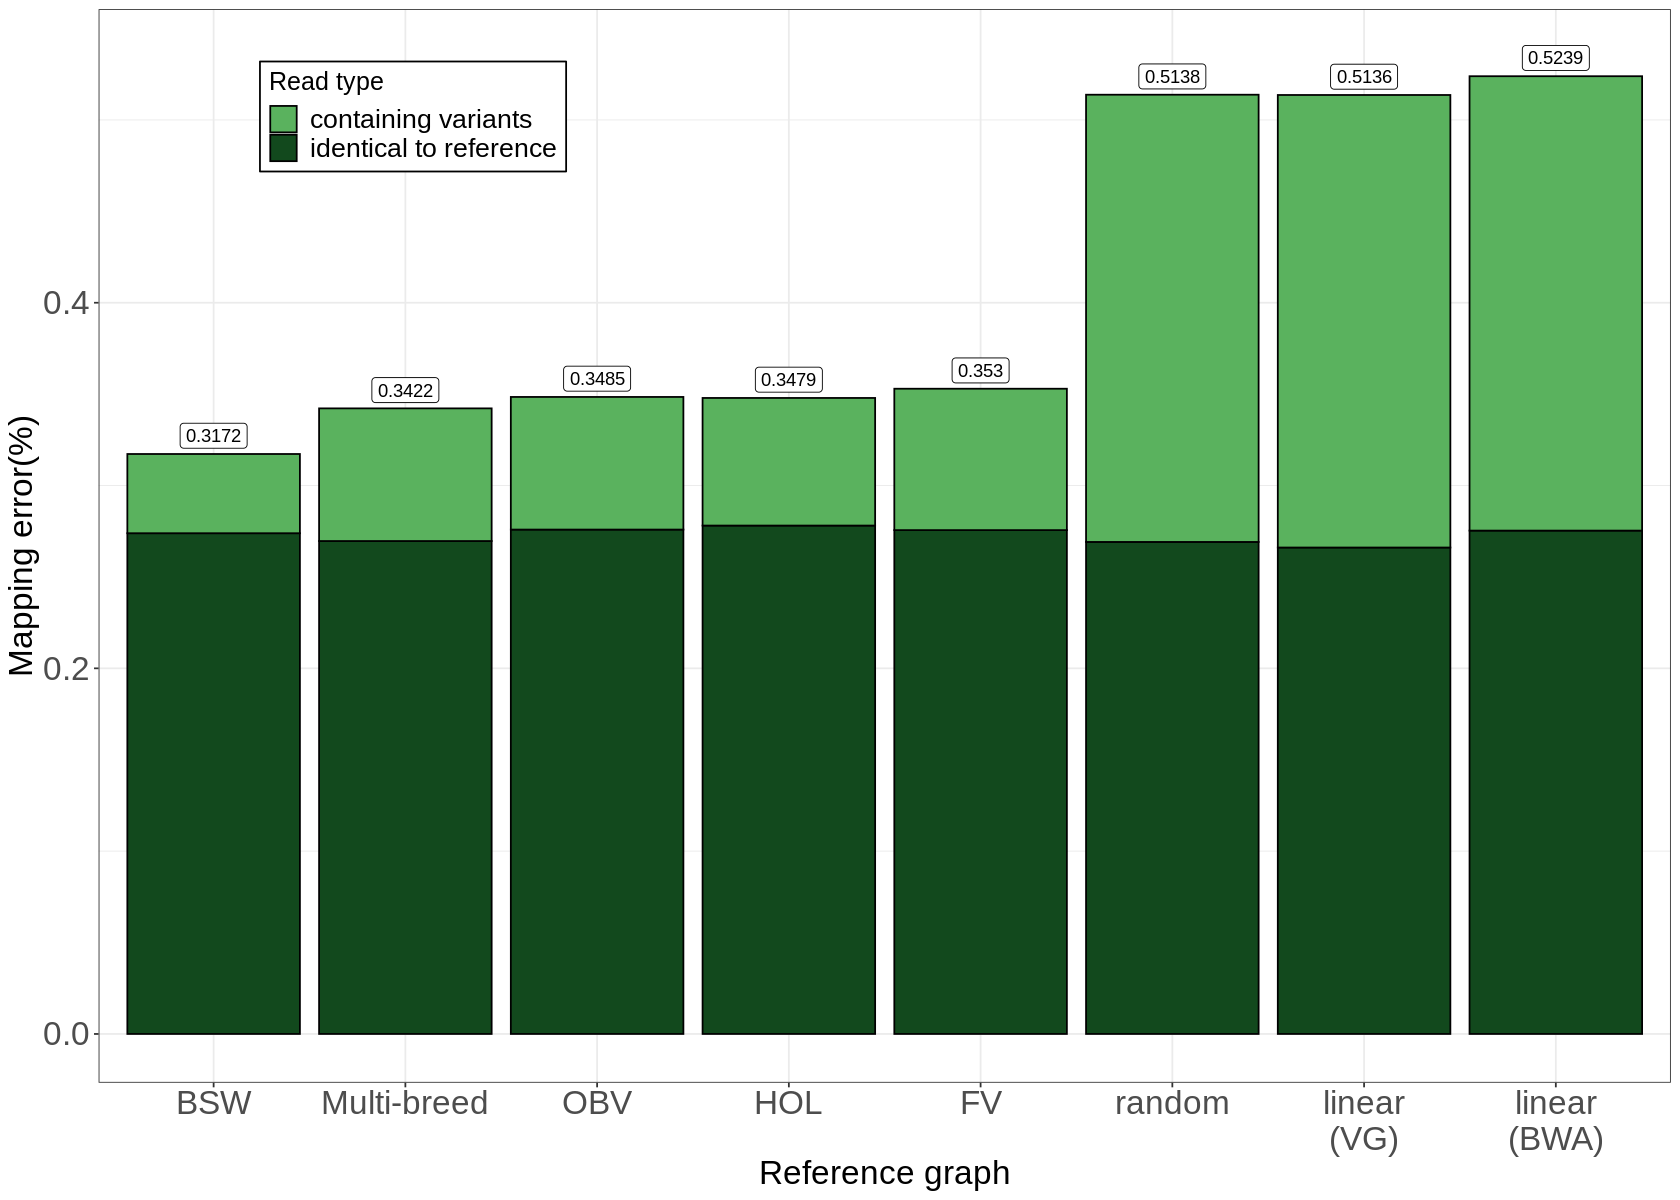

In [31]:
datv2 <- datstat_nov %>% filter(mode=="se") %>% group_by(ident,breeds) %>% 
  summarise(FP=sum(FP)*100/10000000,
            total=sum(total))

datv2_sum <- datv2 %>% group_by(breeds) %>% 
  summarise(total_err=sum(FP))

label_x <- c("BSW","Multi-breed","OBV","HOL","FV","random","linear\n(VG)","linear\n(BWA)")
pl1 <- ggplot(datv2,aes(x=breeds,y=FP)) +
  geom_col(aes(fill=ident),col="black") +
  geom_label(data=datv2_sum,aes(x=breeds,y=total_err+0.01,label=round(total_err,4)),inherit.aes = FALSE)+
  theme_bw()+
  theme(text=element_text(size=20),
        axis.text = element_text(size=20),
        legend.position = c(0.2,0.9),
        legend.title=element_text(size=15),
        legend.background = element_rect(colour="black")) +
  labs(x="Reference graph",y="Mapping error(%)",fill="Read type")+
  scale_fill_manual(values=c("#5AB25E","#12491D"),label=c("containing variants","identical to reference"))+
  scale_x_discrete(label=label_x)


cat("Plot incorrect mapping by read novelty for single-end mapping")
pl1

In [32]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] magrittr_1.5    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.3    
 [5] purrr_0.3.3     readr_1.3.1     tidyr_1.0.0     tibble_2.1.3   
 [9] ggplot2_3.2.1   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_1.0.2  